# Report

In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import os.path as osp
from collections import Counter

import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from redditscore.tokenizer import CrazyTokenizer
from sklearn import metrics
from tqdm import tqdm_notebook

In [36]:
import matplotlib.pyplot as plt
import seaborn
from IPython.display import set_matplotlib_formats
from jupyterthemes import jtplot

jtplot.style()

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

In [37]:
DATA_DIR = r'/media/data/PhD_Projects/kenya/data'
MODEL_DIR = r'/media/data/PhD_Projects/kenya/models'

In [38]:
tokenizer = CrazyTokenizer(
    keepcaps=False,
    ignore_stopwords='english',
    twitter_handles='',
    hashtags='split',
    subreddits='',
    reddit_usernames='',
    emails='',
    urls='')

# User groups

First, we load the user data and create group mappings based on two TXT files

In [39]:
users = pd.read_csv(
    osp.join(DATA_DIR, 'processed', 'all_users.csv'),
    lineterminator='\n',
)
account_groups = pd.read_excel(
    osp.join(DATA_DIR, 'raw', 'churchgroups_fortwitterusers.xls'),
    sheet_name=0)
contain_groups = pd.read_excel(
    osp.join(DATA_DIR, 'raw', 'churchgroups_fortwitterusers.xls'),
    sheet_name=1)
account_mapping = dict(
    zip(account_groups.follows, account_groups.Group.str.strip()))
contain_mapping = dict(
    zip(contain_groups.Variable, contain_groups.Group.str.strip()))

The followers of two accounts haven't been collected (@mavunochurchorg is suspended, @HouseofGraceHQ is just not in the dataset for some reason, can recollect if necessary)

In [40]:
for account, group in account_mapping.items():
    if f'follows_{account}' not in users.columns:
        print(f'follows_{account} not in columns')
    else:
        users.loc[users[f'follows_{account}'] == 1, f'group_{group}'] = 1

for word, group in contain_mapping.items():
    if f'{word}' not in users.columns:
        print(f'{word} not in columns')
    else:
        users.loc[users[f'{word}'] == 1, f'group_{group}'] = 1

follows_mavunochurchorg not in columns
follows_HouseofGraceHQ not in columns


Over 85% of the users belong to single group according to our mapping

number_of_groups
0      649
1    19972
2     2251
3      355
4        3
dtype: int64
                  Percentage
number_of_groups            
0                   0.027938
1                   0.859750
2                   0.096901
3                   0.015282
4                   0.000129


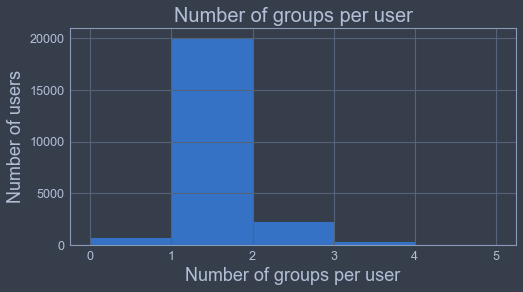

In [41]:
group_cols = list(users.filter(regex='group_', axis=1).columns)
users[group_cols] = users[group_cols].fillna(0)
users['number_of_groups'] = users[group_cols].sum(axis=1).astype(int)
print(users.groupby('number_of_groups').size())
print(
    pd.DataFrame({
        'Percentage':
        users.groupby(('number_of_groups')).size() / len(users)
    }))
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Number of groups per user')
ax.set_ylabel('Number of users')
users['number_of_groups'].hist(bins=[0, 1, 2, 3, 4, 5], ax=ax)

Among users with multiple groups, the most popular combinations are Mainline Protestant + nan, Mainline Protestant + Pentecostal, Pentecostal + nan and Mainline Protestant + Pentecostal + nan

In [42]:
users_multiple = users.loc[users.number_of_groups > 1, group_cols].copy()
users_multiple.groupby(
    users_multiple.columns.tolist(),
    as_index=False).size().to_frame(name='users_num').sort_values(
        by='users_num', ascending=False)

users_num
group_Mainline Protestant group_Pentecostal group_Catholic group_nan           
1.0                       0.0               0.0            1.0              971
                          1.0               0.0            0.0              746
0.0                       1.0               0.0            1.0              479
1.0                       1.0               0.0            1.0              344
                          0.0               1.0            0.0               35
0.0                       0.0               1.0            1.0               14
1.0                       0.0               1.0            1.0                7
0.0                       1.0               1.0            0.0                6
1.0                       1.0               1.0            1.0                3
0.0                       1.0               1.0            1.0                2
1.0                       1.0               1.0            0.0                2

# Tweets

For now, let's keep only users who belong to a single group. Let's also create user-group mappings and calculate the number of users by group. Note that there are a lot of nan (JCCKenya) users

In [58]:
users_single = users.loc[users.number_of_groups == 1, :].copy()
user_mapping = dict(
    zip(users_single['screen_name'], users[group_cols].idxmax(axis=1)))
print(Counter(user_mapping.values()))

Counter({'group_Mainline Protestant': 7752, 'group_nan': 7074, 'group_Pentecostal': 4546, 'group_Catholic': 600})


Next, we load all tweets, remove duplicates and tweets that are out of time range; we also drop tweets for which we couldn't identify a single group

In [60]:
tweets_file = os.path.join(DATA_DIR, 'processed', 'tweets.csv')
tweets = pd.read_csv(
    tweets_file,
    lineterminator='\n',
    error_bad_lines=False,
    usecols=['created_at', 'screen_name', 'id', 'retweet', 'text'])

tweets['created_at'] = pd.to_datetime(
    tweets['created_at'], infer_datetime_format=True, errors='coerce')
tweets['mnth_yr'] = tweets['created_at'].dt.to_period('M')
tweets = tweets.loc[(tweets.created_at >= '2013-03-01')
                    & (tweets.created_at < '2017-12-01')]

tweets['id'] = pd.to_numeric(tweets['id'])
tweets.drop_duplicates('id', inplace=True)

tweets['group'] = tweets['screen_name'].map(user_mapping)
tweets.dropna(subset=['group'], inplace=True)

/home/crazyfrogspb/.local/share/virtualenvs/kenya/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Some descriptive statistics and graphs

In [61]:
print(f'Dataset size: {tweets.shape}')
print(f'Unique users: {len(tweets.screen_name.unique())}')
print(f"Number of tweets per group: {tweets.groupby('group').size()}")

Dataset size: (8662562, 7)
Unique users: 15803
Number of tweets per group: group
group_Catholic                265013
group_Mainline Protestant    3477781
group_Pentecostal            1952127
group_nan                    2967641
dtype: int64


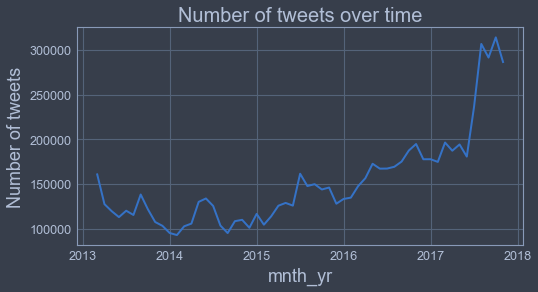

In [62]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Month')
ax.set_ylabel('Number of tweets')
ax.set_title('Number of tweets over time')
tweets.groupby('mnth_yr').size().plot(ax=ax)

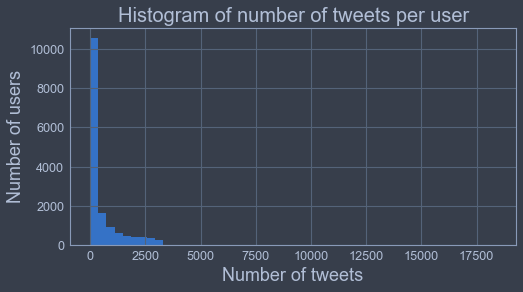

In [63]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Number of tweets')
ax.set_ylabel('Number of users')
ax.set_title('Histogram of number of tweets per user')
tweets.groupby('screen_name').size().hist(bins=50)

## Politicalness

Let's load Word2Vec model pretrained on the sample of 500000 Kenyan tweets and define functions that we need for calculating political scores. Here, we use snowballing technique: starting with a small sample of politicall related words, we then gradually add more words that are most similar to the current dictionary

In [72]:
w2v_model = Word2Vec.load(osp.join(MODEL_DIR, 'w2v.model'))

In [156]:
def snowball(model, start_list, threshold=0.5, limit_voc=150, step=1, min_freq=2):
    vocab = list(start_list)
    
    for i in range(len(w2v_model.wv.vocab)):
        word = w2v_model.wv.index2word[i]
        freq = w2v_model.wv.vocab[word].count
        limit = i
        if freq < min_freq:
            break
            
    while len(vocab) <= limit_voc:
        words = model.wv.most_similar(positive=vocab, topn=step, restrict_vocab=limit)
        words = [word for word, sim in words if sim >= threshold]
        if words:
            vocab.extend(words)
        else:
            break
    return vocab[0:limit_voc]


def list_similarity(new_list, ref_list, model):
    new_list_clean = [word for word in new_list if word in model.wv]
    if new_list_clean:
        return model.wv.n_similarity(ref_list, new_list_clean)
    else:
        return np.nan


def calc_w2v_scores(tweets, model, word_tuples):
    for name, word_list in word_tuples:
        tweets[name] = tweets['tokens'].apply(
            list_similarity, ref_list=word_list, model=model)
    return tweets

Let's generate expanded list of political words

In [157]:
political_words = [
    'politics', 'government', 'campaign', 'election', 'vote', 'ideology',
    'political', 'democracy', 'president', 'partisan', 'corruption', 'reform'
]
political_words_aug = snowball(w2v_model, political_words)
print(political_words_aug)

['politics', 'government', 'campaign', 'election', 'vote', 'ideology', 'political', 'democracy', 'president', 'partisan', 'corruption', 'reform', 'electoral', 'electorate', 'democratic', 'referendum', 'constitutional', 'coalition', 'parties', 'opposition', 'majority', 'independent', 'opposed', 'legitimacy', 'negotiated', 'dictatorship', 'presidency', 'rigging', 'despots', 'legally', 'unconstitutional', 'intimidation', 'interference', 'elites', 'politically', 'judiciary', 'bribery', "gov't", 'regime', 'illegitimate', 'oppose', 'dismissed', 'allegations', 'jurisdiction', 'threaten', 'removal', 'jsc', 'anarchy', 'purported', 'suspend', 'fraudulent', 'complicit', 'defended', 'intolerance', 'prosecute', 'outright', 'interfering', 'prosecution', 'tribunal', 'opposing', 'tyrants', 'baseless', 'dissent', 'disregard', 'appointive', 'crimes', 'abuses', 'advises', 'stance', 'illegalities', 'duplicitous', 'gov’t', 'irregularities', 'rejecting', 'purport', 'duress', 'commision', 'unfit', 'scork', '

Now we load validation data and generate political scores

In [158]:
def tokenize(df):
    tokens = []
    for i in tqdm_notebook(range(df.shape[0])):
        current_tokens = tokenizer.tokenize(
            df.iloc[i, df.columns.get_loc('text')])
        tokens.append(current_tokens)
    return tokens

In [159]:
validated_tweets = pd.read_stata(
    os.path.join(DATA_DIR, 'raw', 'validation_sample_bothcoders.dta'))

validated_tweets['tokens'] = tokenize(validated_tweets)
validated_tweets = validated_tweets.loc[validated_tweets.tokens.str.
                                        len() > 1, :]
validated_tweets['W2V_political'] = validated_tweets['tokens'].apply(
    list_similarity, ref_list=political_words_aug, model=w2v_model)

Correlation of political scores with coder_1 is 0.64, with coder_2 - 0.74

In [160]:
validated_tweets.corr()

,coder_2,id,coder_1,W2V_political
coder_2,1.000000,0.177303,0.617595,0.743644
id,0.177303,1.000000,0.210739,0.232743
coder_1,0.617595,0.210739,1.000000,0.643747
W2V_political,0.743644,0.232743,0.643747,1.000000


Let's choose threshold for political score that gives the highest accuracy (according to coder_2). We can achieve 86% accuracy. Precision is 89% (meaning that 89% of tweets identified as political are indeed political), recall is 81% (we can successfully identify 81% of political tweets from the validation dataset)

In [162]:
best_acc = 0.0
for t in np.arange(0.0, 1.01, 0.01):
    predictions = np.where(validated_tweets['W2V_political'] >= t, 1, 0)
    acc = metrics.accuracy_score(validated_tweets['coder_2'], predictions)
    if acc > best_acc:
        best_t = t
        best_acc = acc
print(f'Best threshold: {best_t}, best accuracy: {round(best_acc, 3)}')
predictions = np.where(validated_tweets['W2V_political'] >= best_t, 1, 0)
precision = metrics.precision_score(validated_tweets['coder_2'], predictions)
recall = metrics.recall_score(validated_tweets['coder_2'], predictions)
print(f'Precision: {round(precision, 3)}, recall: {round(recall, 3)}')

Best threshold: 0.33, best accuracy: 0.8625
Precision: 0.8888888888888888, recall: 0.8085106382978723


### Analysis

Now we can apply these rules to all tweets to calculate different statistics for the different group of users

In [163]:
def minibatch_iterator(df, batch_size):
    indices = np.arange(df.shape[0])
    for idx in range(0, df.shape[0], batch_size):
        batch_ind = indices[idx:min(idx + batch_size, df.shape[0])]
        yield df.iloc[batch_ind, :].copy()

In [ ]:
political_scores = []
for batch in minibatch_iterator(tweets, 1000000):
    batch['tokens'] = tokenize(batch)
    political_scores.extend(batch['tokens'].apply(
        list_similarity, ref_list=political_words_aug, model=w2v_model))

In [ ]:
tweets['W2V_political'] = political_scores
tweets['is_political'] = np.where(tweets['W2V_political'] >= best_t, 1, 0)

In [ ]:
tweets[['id', 'W2v_political', 'is_political']].to_csv(osp.join(DATA_DIR, 'processed', 'tweets_scores.csv'), index=False)

Let's look at some descriptive stats

In [ ]:
print(tweets['W2V_political'].describe())
print(tweets.groupby('is_political').size().to_frame(n='political_tweets'))

Now we can finally look at the mean and median values of:
1) political scores
2) percentage of political tweets by group

In [ ]:
tweets_gr = tweets.groupby('group')[['is_political', 'W2V_politicall']].agg(['mean', 'median'])